In [4]:
import bz2
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.manifold import TSNE

from utils import read_file

In [3]:
with open("/sciclone/geograd/stmorse/reddit/subreddit/science/links/graph_2007-2007_filtered.json") as f:
    graph = json.load(f)
graph.keys()

dict_keys(['user_to_idx', 'edge_index', 'edge_weight'])

In [14]:
# Convert the edge index lists into edge tuples
edges = list(zip(graph['edge_index'][0], graph['edge_index'][1]))

# Create an undirected graph (change to nx.DiGraph() if needed)
G = nx.Graph()
G.add_edges_from(edges)

# Filter out nodes that have only one edge
# nodes_to_keep = [node for node, degree in G.degree() if degree > 1]
# H = G.subgraph(nodes_to_keep)

# Get the largest connected component
largest_cc = max(nx.connected_components(G), key=len)
H = G.subgraph(largest_cc)

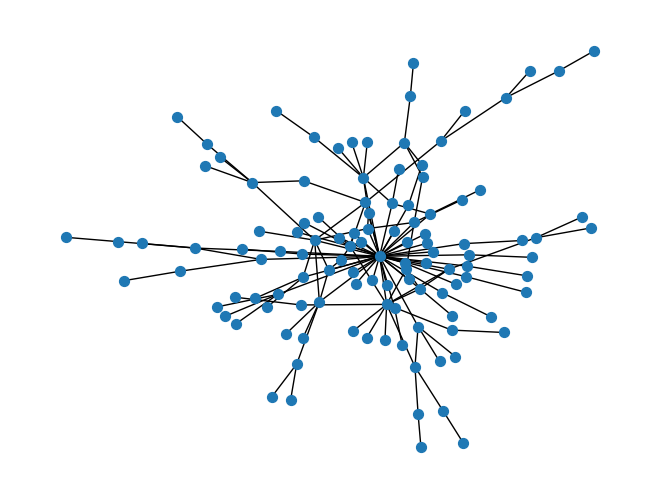

In [15]:
# Generate positions for all nodes using a layout algorithm
pos = nx.spring_layout(H, seed=42)

# Draw the graph with node labels and arrows
nx.draw(H, pos, with_labels=False, node_size=50)
plt.show()

In [16]:
# Convert the edge index lists and corresponding weights into a list of weighted edges
edges_with_weights = list(zip(graph['edge_index'][0],
                              graph['edge_index'][1],
                              graph['edge_weight']))

# Create an undirected weighted graph
G = nx.Graph()
for u, v, w in edges_with_weights:
    G.add_edge(u, v, weight=w)

# Get the largest connected component
largest_cc = max(nx.connected_components(G), key=len)
H = G.subgraph(largest_cc)

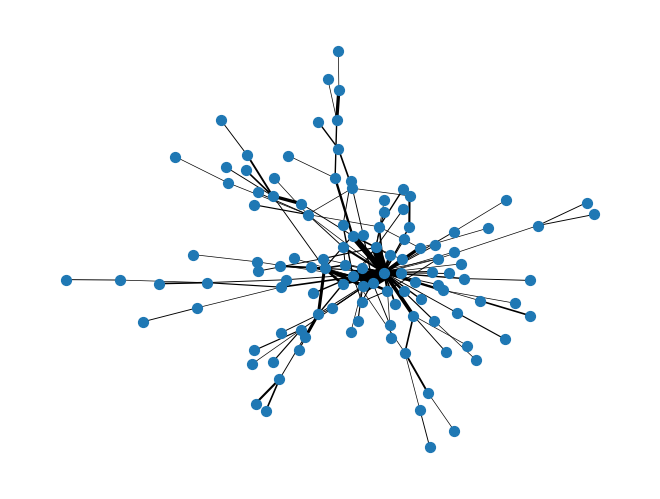

In [18]:
# Generate positions for the nodes using a layout algorithm
pos = nx.spring_layout(H, seed=42)

# Extract weights from each edge in the component
weights = [H[u][v]['weight'] for u, v in H.edges()]

# Optionally, scale edge widths (this scales weights between 0.5 and 5)
min_w, max_w = min(weights), max(weights)
scale = 10 / (max_w - min_w) if max_w != min_w else 1
edge_widths = [(w - min_w) * scale + 0.5 for w in weights]

# Draw the graph with edge widths proportional to their weight
nx.draw(H, pos, with_labels=False, node_size=50, width=edge_widths)
plt.show()

In [2]:
u0 = np.load("/sciclone/geograd/stmorse/reddit/subreddit/science/users/user_label_counts_2007_filtered.csv.npy")
u0.shape

(503, 15)

In [19]:
z = pd.read_csv("/sciclone/geograd/stmorse/reddit/subreddit/science/users/user_label_counts_2008.csv")
z.head()

,author,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-J-,0,0,1,0,1,1,4,0,0,5,2,2,1,0,0
1,02J,3,0,4,0,1,0,2,0,1,0,1,0,0,1,0
2,0_o,3,0,0,0,1,0,0,0,1,3,1,1,0,0,2
3,0gleth0rpe,1,0,0,1,0,2,2,0,0,3,0,0,3,0,0
4,0x44,0,0,0,1,1,0,0,0,0,2,3,0,2,1,0


In [20]:
z.shape

(2634, 16)

- "subreddit":"reddit.com",
- "score":3,
- "ups":3,
- "author_flair_css_class":null,
- "created_utc":1167609605,
- "body":"In the city I live in, I probably am.  Might even be the entire island.  Ah well.  It\'s one thing to know that somewhere, out there over the Internet, there are many like me.  It\'s another thing to know someone, in my everyday life off the internet, who is like me too.\\r\\n\\r\\nPixels on a screen just aren\'t enough.\\r\\n\\r\\nLife is a sadness.  But what else can we do but live it?  Life is a happiness.  But what else can we do but endure it?\\r\\n",
- "controversiality":0,
- "subreddit_id":"t5_6",
- "link_id":"t3_wiw8",
- "stickied":false,
- "gilded":0,
- "distinguished":null,
- "retrieved_on":1473809765,
- "author":"almkglor",
- "author_flair_text":null,
- "id":"cwl3r",
- "edited":false,
- "parent_id":"t1_cwjuc"

link_id is submission id
parent_id is t1_id for child comment, t3_id for top level comment

In [8]:
meta1 = pd.read_csv('/sciclone/geograd/stmorse/reddit/metadata/metadata_2007-01.csv', compression='gzip')
meta2 = pd.read_csv('/sciclone/geograd/stmorse/reddit/metadata/metadata_2007-02.csv', compression='gzip')
meta2.head()

,id,created_utc,parent_id,subreddit,subreddit_id,author,idx
0,c128oj,1170288047,t1_c124gv,programming,t5_2fwo,dons,0
1,c128ok,1170288055,t3_127fd,reddit.com,t5_6,indigoshift,1
2,c128ot,1170288082,t1_c128nr,reddit.com,t5_6,rutabaga,2
3,c128ov,1170288082,t1_c127e3,reddit.com,t5_6,dotrob,3
4,c128p3,1170288120,t3_121yo,programming,t5_2fwo,justinhj,4


In [10]:
meta1.query('id == "c128nr"')

,id,created_utc,parent_id,subreddit,subreddit_id,author,idx
58946,c128nr,1170287830,t3_127g7,reddit.com,t5_6,rutabaga,58946


In [13]:
with open('/sciclone/geograd/stmorse/reddit/links/graph.json', 'r') as f:
    z = json.load(f)

In [16]:
z['edge_index'][0][:5], z['edge_index'][1][:5], z['edge_weight'][:5]

([270, 2765, 2698, 2698, 1378],
 [2333, 3614, 2765, 3614, 2333],
 [1, 1, 1, 1, 1])

In [21]:
z2 = np.array(z['edge_weight'])
np.where(z2 > 10)

(array([  177,   212,   516,   637,   745,   775,   780,   947,  1004,
         1989,  2048,  2249,  2968,  2977,  3056,  3264,  3592,  4289,
         4608,  4743,  4799,  4877,  4902,  4965,  5021,  5025,  5638,
         5675,  6276,  6335,  6371,  6391,  7020,  7031,  8837,  9069,
         9081,  9082,  9670,  9677, 10657, 10847, 11264, 11385, 11991,
        12085, 12166, 12724, 13243, 13293, 13417, 13511, 13520, 13618,
        14299, 14616, 14690, 15297, 15417, 16004, 16387, 16416, 16435,
        16467, 17190, 17273, 18789, 18982, 19128, 19252, 19384, 20104,
        20160, 21472, 21566, 22185, 22443, 22543]),)

In [4]:
df = pd.read_csv('/sciclone/geograd/stmorse/reddit/subreddit/science/users/user_label_counts_2008.csv')
df.head()

,author,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-J-,0,0,1,0,1,1,4,0,0,5,2,2,1,0,0
1,02J,3,0,4,0,1,0,2,0,1,0,1,0,0,1,0
2,0_o,3,0,0,0,1,0,0,0,1,3,1,1,0,0,2
3,0gleth0rpe,1,0,0,1,0,2,2,0,0,3,0,0,3,0,0
4,0x44,0,0,0,1,1,0,0,0,0,2,3,0,2,1,0


In [6]:
t = df.drop(columns=['author']).values
l2_norms = np.sqrt(np.sum(t**2, axis=1, keepdims=True))
normalized_t = t / l2_norms
normalized_t[:5,:]

array([[0.        , 0.        , 0.13736056, 0.        , 0.13736056,
        0.13736056, 0.54944226, 0.        , 0.        , 0.68680282,
        0.27472113, 0.27472113, 0.13736056, 0.        , 0.        ],
       [0.52223297, 0.        , 0.69631062, 0.        , 0.17407766,
        0.        , 0.34815531, 0.        , 0.17407766, 0.        ,
        0.17407766, 0.        , 0.        , 0.17407766, 0.        ],
       [0.58834841, 0.        , 0.        , 0.        , 0.19611614,
        0.        , 0.        , 0.        , 0.19611614, 0.58834841,
        0.19611614, 0.19611614, 0.        , 0.        , 0.39223227],
       [0.18898224, 0.        , 0.        , 0.18898224, 0.        ,
        0.37796447, 0.37796447, 0.        , 0.        , 0.56694671,
        0.        , 0.        , 0.56694671, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.2236068 , 0.2236068 ,
        0.        , 0.        , 0.        , 0.        , 0.4472136 ,
        0.67082039, 0.        , 0.4472136 , 

In [8]:
tt = TSNE(n_components=2).fit_transform(normalized_t)

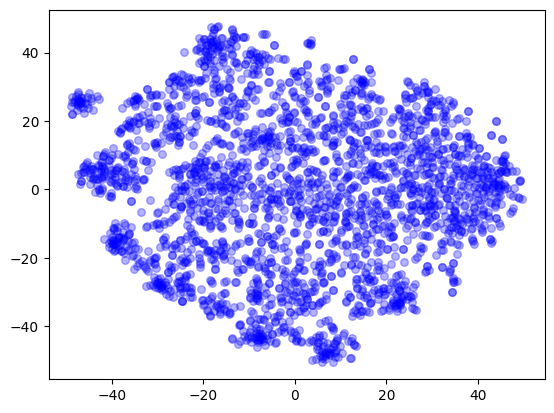

In [9]:
plt.scatter(tt[:,0], tt[:,1], s=30, c='b', alpha=0.3)

In [10]:
meta = pd.read_csv('/sciclone/geograd/stmorse/reddit/metadata/metadata_2007-01.csv', compression='gzip')
meta.head()

,id,created_utc,parent_id,subreddit,subreddit_id,author,idx
0,cwl3r,1167609605,t1_cwjuc,reddit.com,t5_6,almkglor,0
1,cwl3s,1167609743,t1_cwjys,reddit.com,t5_6,hitsman,1
2,cwl3t,1167609769,t3_wjui,reddit.com,t5_6,raldi,2
3,cwl3w,1167609826,t1_cwl34,reddit.com,t5_6,neoform,3
4,cwl3x,1167609856,t3_wl3v,reddit.com,t5_6,hotmama420,4


In [13]:
with open('/sciclone/geograd/stmorse/reddit/subreddit/science/links/graph_2007-2007.json') as f:
    graph = json.load(f)
graph.keys()

dict_keys(['user_to_idx', 'edge_index', 'edge_weight'])

In [14]:
graph['user_to_idx']

{'00u6166': 0,
 '0110110101101011': 1,
 '02J': 2,
 '09amw': 3,
 '0ntarget': 4,
 '0wnagetime': 5,
 '0x44': 6,
 '0xdefec8': 7,
 '1101010001': 8,
 '1239448837': 9,
 '12413515': 10,
 '1492': 11,
 '1812overture': 12,
 '1amgreat': 13,
 '238837426': 14,
 '24sparky': 15,
 '27182818284': 16,
 '2ndrateidiot': 17,
 '2pac2pac2': 18,
 '2stupid': 19,
 '300zedex': 20,
 '315was_an_inside_job': 21,
 '3n7r0py': 22,
 '42omle': 23,
 '4609287645': 24,
 '50evactab': 25,
 '54gy6dm': 26,
 '570': 27,
 '5P4C3M4N5P1FF': 28,
 '60secs': 29,
 '711was_a_retail_job': 30,
 '711was_an_inside_job': 31,
 '7oby': 32,
 '911WasntAnOutsideJob': 33,
 '911_was_a_job': 34,
 '911_was_an_inside_jo': 35,
 '9jack9': 36,
 '9ner': 37,
 'A-Pothead': 38,
 'ABeZero': 39,
 'ABentSpoon': 40,
 'AM088': 41,
 'AMerrickanGirl': 42,
 'AMessagetoURudy': 43,
 'ANRAND': 44,
 'ASmileInHisShoes': 45,
 'ATh90': 46,
 'AaronRowe': 47,
 'AbouBenAdhem': 48,
 'AdamAtlas': 49,
 'AdamPan': 50,
 'Admiral-Evident': 51,
 'AdmiralBumblebee': 52,
 'Adrewmc': 53